In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

from metric_learn import LMNN
from sklearn.model_selection import StratifiedKFold

In [2]:
data = loadmat('PaviaU.mat')['paviaU']

gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))  #düzleştirip dataframe oluşturuyoruz

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

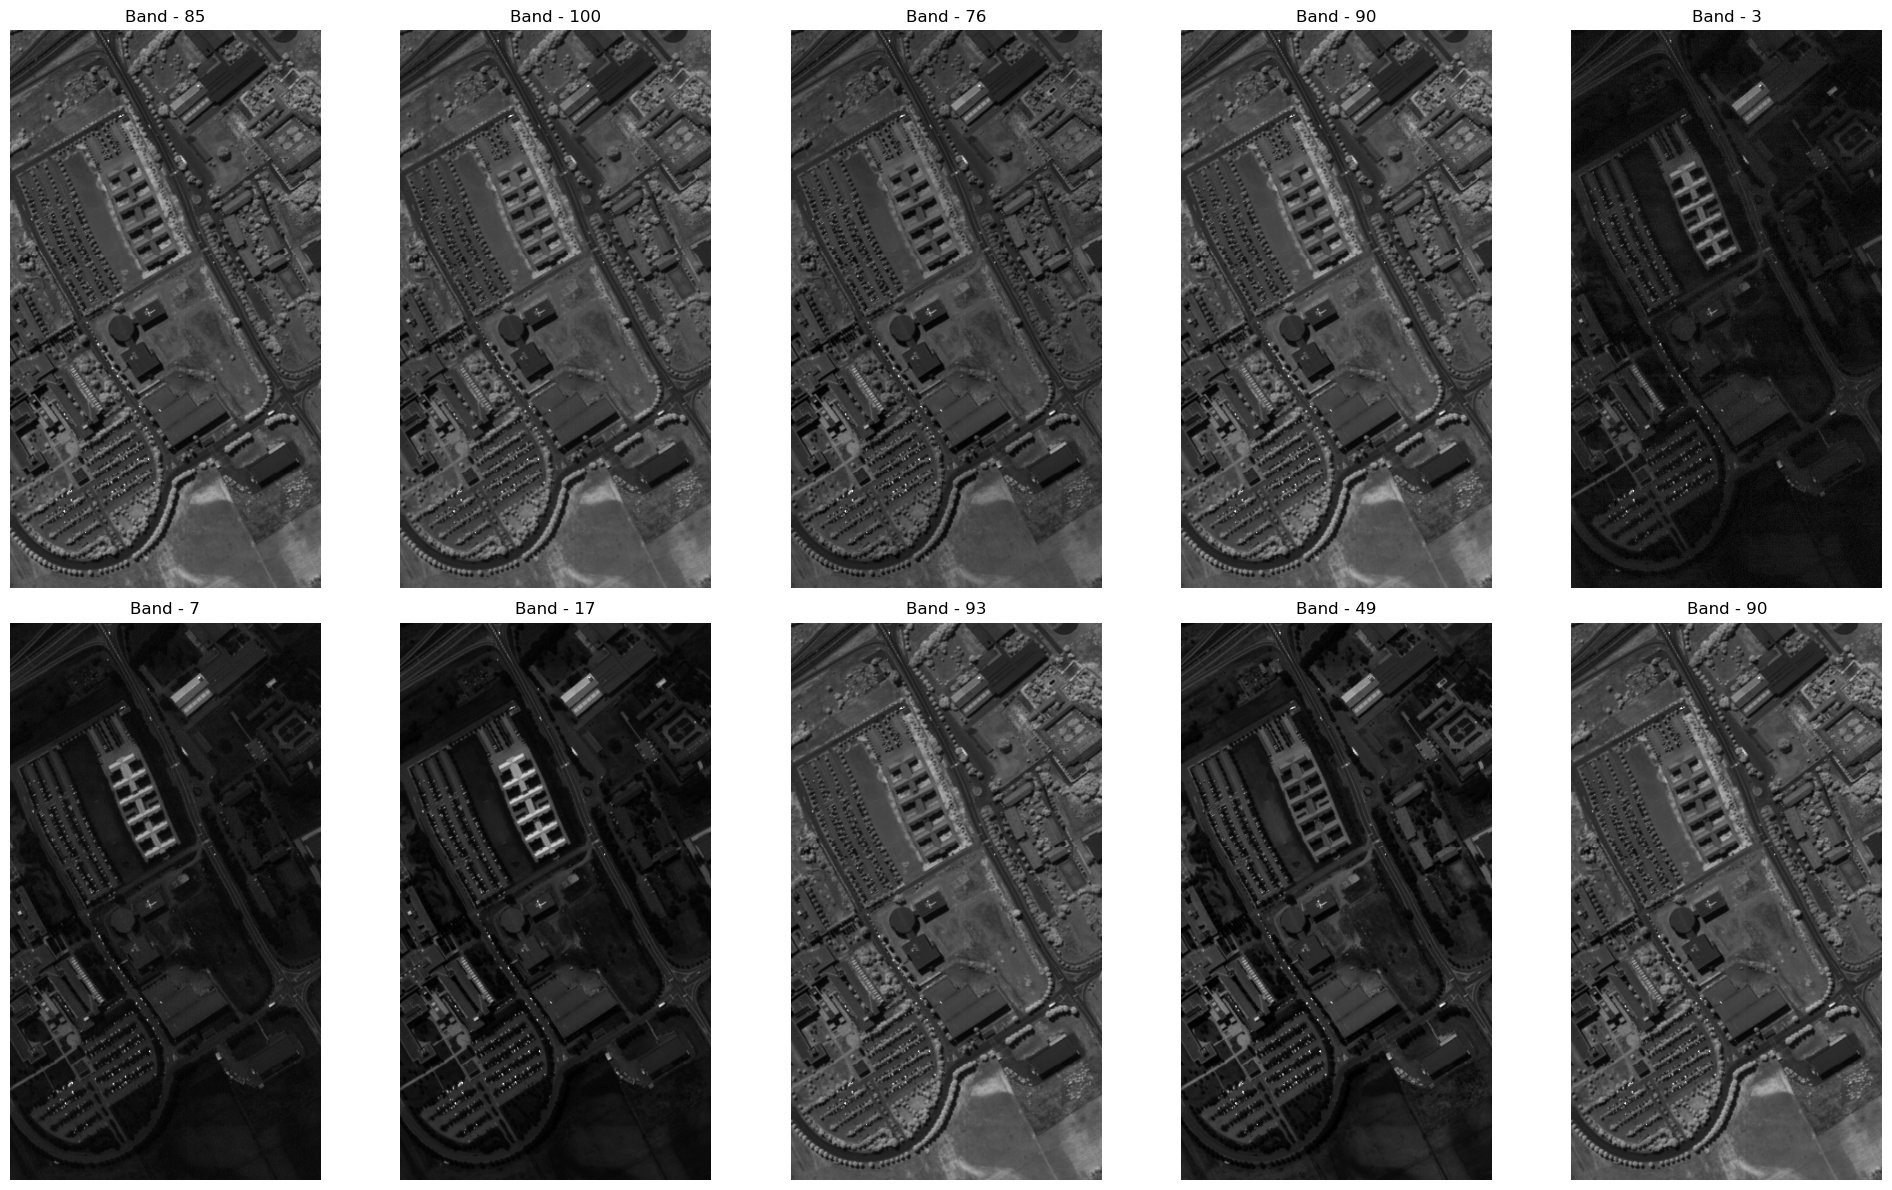

In [3]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()

plt.show()

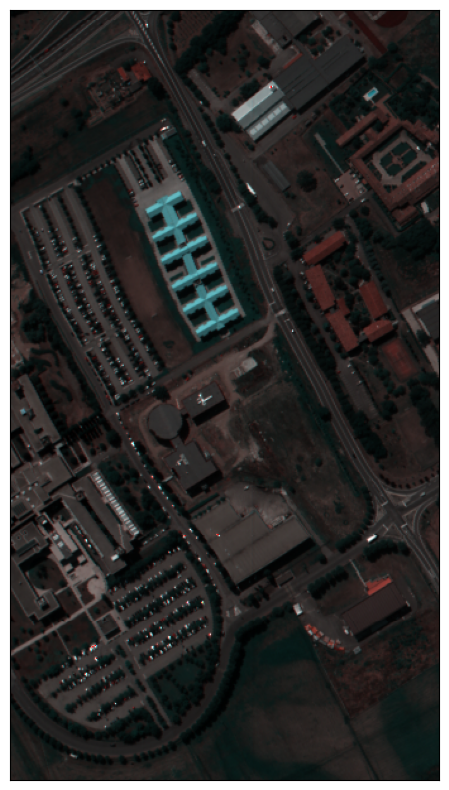

In [4]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10))

plt.show()

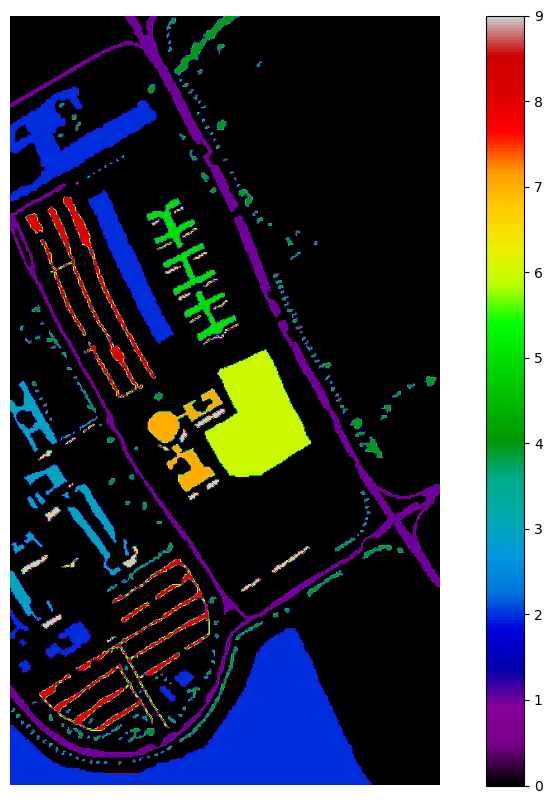

In [5]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [6]:
X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [7]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import MMC_Supervised

veri = []

# Model için parametreler
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mmc = MMC_Supervised(n_constraints=1)
knn = KNeighborsClassifier(n_neighbors=7)

fold_index = 1
for test_index, train_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    # Veri setini train ve test olarak bölmek
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modeli eğitme
    mmc.fit(X_train, y_train)
    knn.fit(mmc.transform(X_train), y_train)


    mmc_acc = knn.score(mmc.transform(X_test), y_test)
    print('MMC_Supervised accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], mmc_acc))

    veri.append(mmc_acc)

    fold_index += 1
    
# Dizinin ortalamasını bulalım
ortalama = np.mean(veri)

# Dizinin standart sapmasını bulalım
standart_sapma = np.std(veri)

print("Veri kümesinin ortalaması:", ortalama)
print("Veri kümesinin standart sapması:", standart_sapma)

Fold 1 -> Train: 8556, Test: 34220
MMC_Supervised accuracy on test set of 34220 points: 0.8362
Fold 2 -> Train: 8555, Test: 34221
MMC_Supervised accuracy on test set of 34221 points: 0.8538
Fold 3 -> Train: 8555, Test: 34221
MMC_Supervised accuracy on test set of 34221 points: 0.8598
Fold 4 -> Train: 8555, Test: 34221
MMC_Supervised accuracy on test set of 34221 points: 0.8532
Fold 5 -> Train: 8555, Test: 34221
MMC_Supervised accuracy on test set of 34221 points: 0.8553
Veri kümesinin ortalaması: 0.851663225715901
Veri kümesinin standart sapması: 0.008055473332180268


In [8]:
y_pred = knn.predict(mmc.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8552643113877444
Confusion Matrix:
[[ 4639    25   157     0    11    61   271   158     0]
 [    0 14509     1   150     0   330     0     5     0]
 [  160     6  1116     0     0     8     4   402     0]
 [    0   465     0  1911     3    10     0     0     1]
 [    4     0     1     0  1071     3     0     2     0]
 [   19  1896     4     1     0  2052     0    15     0]
 [  191     1    17     0     0     0   845    10     0]
 [  148    19   366     0     0    19     7  2376     0]
 [    2     0     0     0     0     0     0     0   749]]
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.87      0.88      5322
           2       0.86      0.97      0.91     14995
           3       0.67      0.66      0.66      1696
           4       0.93      0.80      0.86      2390
           5       0.99      0.99      0.99      1081
           6       0.83      0.51      0.63      3987
           7       0.75      0.79    

In [9]:
from sklearn.metrics import accuracy_score

# Genel doğruluk hesaplama
genel_dogruluk = accuracy_score(y_test, y_pred)
print("Genel Doğruluk:", genel_dogruluk)

Genel Doğruluk: 0.8552643113877444


In [10]:
from sklearn.metrics import f1_score

# F-Measure hesaplama
f_measure = f1_score(y_test, y_pred, average='macro')
print("F-Measure:", f_measure)

F-Measure: 0.8349821263092304


In [11]:
from sklearn.metrics import cohen_kappa_score

# Kappa değeri hesaplama
kappa_degeri = cohen_kappa_score(y_test, y_pred)
print("Kappa Değeri:", kappa_degeri)

Kappa Değeri: 0.8030428223765729
